In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))  # normalise to range [0, 1]
])

In [4]:
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.19MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
def visualise_mnist(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.show()

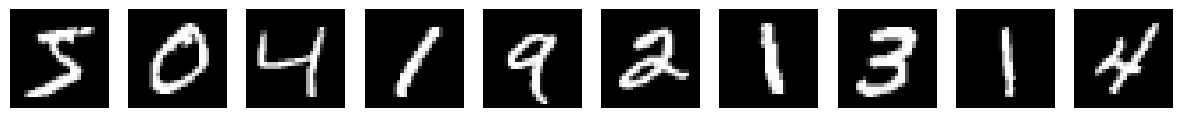

In [9]:
visualise_mnist(train_dataset)

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)  # project to mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # project to log-variance
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [11]:
def reparameterise(mu, logvar):
    std = torch.exp(0.5 * logvar)  # convert log variance to standard deviation
    eps = torch.randn_like(std)  # sample from standard Gaussian (N(0,1))
    return mu + std * eps  # transform standard Gaussian to z

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 28 * 28)
    
    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # output between [0,1]
        return x.view(-1, 1, 28, 28)  # image format reshaping (B, C, H, W)

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

In [15]:
def loss_function(recon_x, x, mu, logvar):
    x = torch.clamp(x, 0, 1)  # x is strictly in [0,1]
    recon_x = torch.clamp(recon_x, 1e-6, 1 - 1e-6)  # avoiding log issues in BCE
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [16]:
vae = VAE(latent_dim=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [17]:
def train(epochs=10):
    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

In [18]:
train(10)

Epoch 1, Loss: 182.9943
Epoch 2, Loss: 159.9759
Epoch 3, Loss: 154.0073
Epoch 4, Loss: 150.4258
Epoch 5, Loss: 148.0290
Epoch 6, Loss: 146.6548
Epoch 7, Loss: 145.3430
Epoch 8, Loss: 144.6439
Epoch 9, Loss: 143.8616
Epoch 10, Loss: 143.0691


In [19]:
def generate_images(num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, 2).to(device)  # sampling from N(0,1)
        samples = vae.decoder(z).cpu()
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].squeeze(), cmap="gray")
            axes[i].axis("off")
        plt.show()

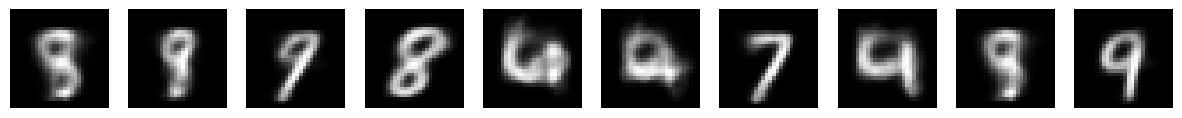

In [20]:
generate_images()

In [23]:
def visualise_latent_space():
    vae.eval()
    latents, labels = [], []
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, logvar = vae.encoder(data)
            z = reparameterise(mu, logvar)
            latents.append(z.cpu().numpy())
            labels.append(label.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)
    plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.show()

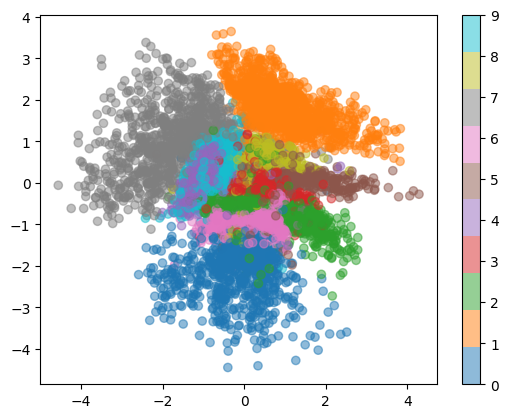

In [24]:
visualise_latent_space()

In [27]:
def interpolate_images():
    vae.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        img1, img2 = data[22].to(device), data[12].to(device)
        mu1, logvar1 = vae.encoder(img1.unsqueeze(0))
        mu2, logvar2 = vae.encoder(img2.unsqueeze(0))
        z1, z2 = reparameterise(mu1, logvar1), reparameterise(mu2, logvar2)
        alphas = np.linspace(0, 1, 10)
        interpolated_images = [vae.decoder((1 - a) * z1 + a * z2).cpu() for a in alphas]
        fig, axes = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axes[i].imshow(interpolated_images[i].squeeze(), cmap="gray")
            axes[i].axis("off")
        plt.show()


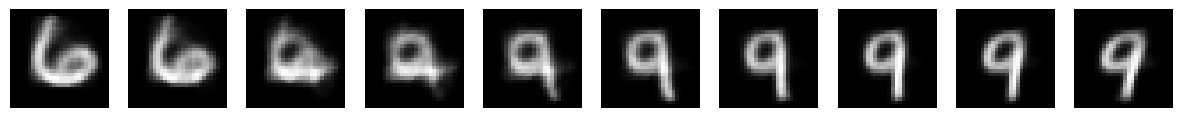

In [28]:
interpolate_images()